In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should show "RTX 3060"


True
NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp

c:\Users\shado\anaconda3\envs\transattunet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%%writefile dataset_isic.py
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image
import random
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import random
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# --- 1. THE FIXED DATASET CLASS ---
class ISICSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, img_size=256, augment=True):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir) if mask_dir is not None else None

        # Use rglob to find all images (recursive search)
        self.img_paths = sorted(
            list(self.img_dir.rglob("*.jpg")) +
            list(self.img_dir.rglob("*.png"))
        )

        self.img_size = img_size
        self.augment = augment
        self.has_masks = mask_dir is not None

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # load mask if available
        if self.has_masks:
            # --- CRITICAL FIX: ADD _segmentation SUFFIX ---
            mask_name = img_path.stem + "_segmentation.png"
            mask_path = self.mask_dir / mask_name

            if not mask_path.exists():
                # Fallback check
                if (self.mask_dir / (img_path.stem + ".png")).exists():
                     mask_path = self.mask_dir / (img_path.stem + ".png")
                else:
                    raise FileNotFoundError(f"Mask not found: {mask_path}")

            mask = Image.open(mask_path).convert("L")
        else:
            mask = None

        # augmentations
        if self.augment:
            if random.random() > 0.5:
                img = TF.hflip(img)
                if mask is not None: mask = TF.hflip(mask)
            if random.random() > 0.5:
                img = TF.vflip(img)
                if mask is not None: mask = TF.vflip(mask)

        # resize
        img = TF.resize(img, (self.img_size, self.img_size))
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

        # mask processing
        if mask is not None:
            mask = TF.resize(mask, (self.img_size, self.img_size))
            mask = TF.to_tensor(mask)
            mask = (mask > 0.5).float()

        return img, mask


Overwriting dataset_isic.py


In [ ]:
from dataset_isic import ISICSegDataset
print("Loaded successfully!")

Loaded successfully!


In [ ]:
train_loader, val_loader = get_loaders(
    base_path="C:\\reimplementation\\data\\isic_dataset",
    batch_size=4,
    img_size=256
)


Dataset Split: 2334 Training, 260 Validation


Displaying 4 samples...


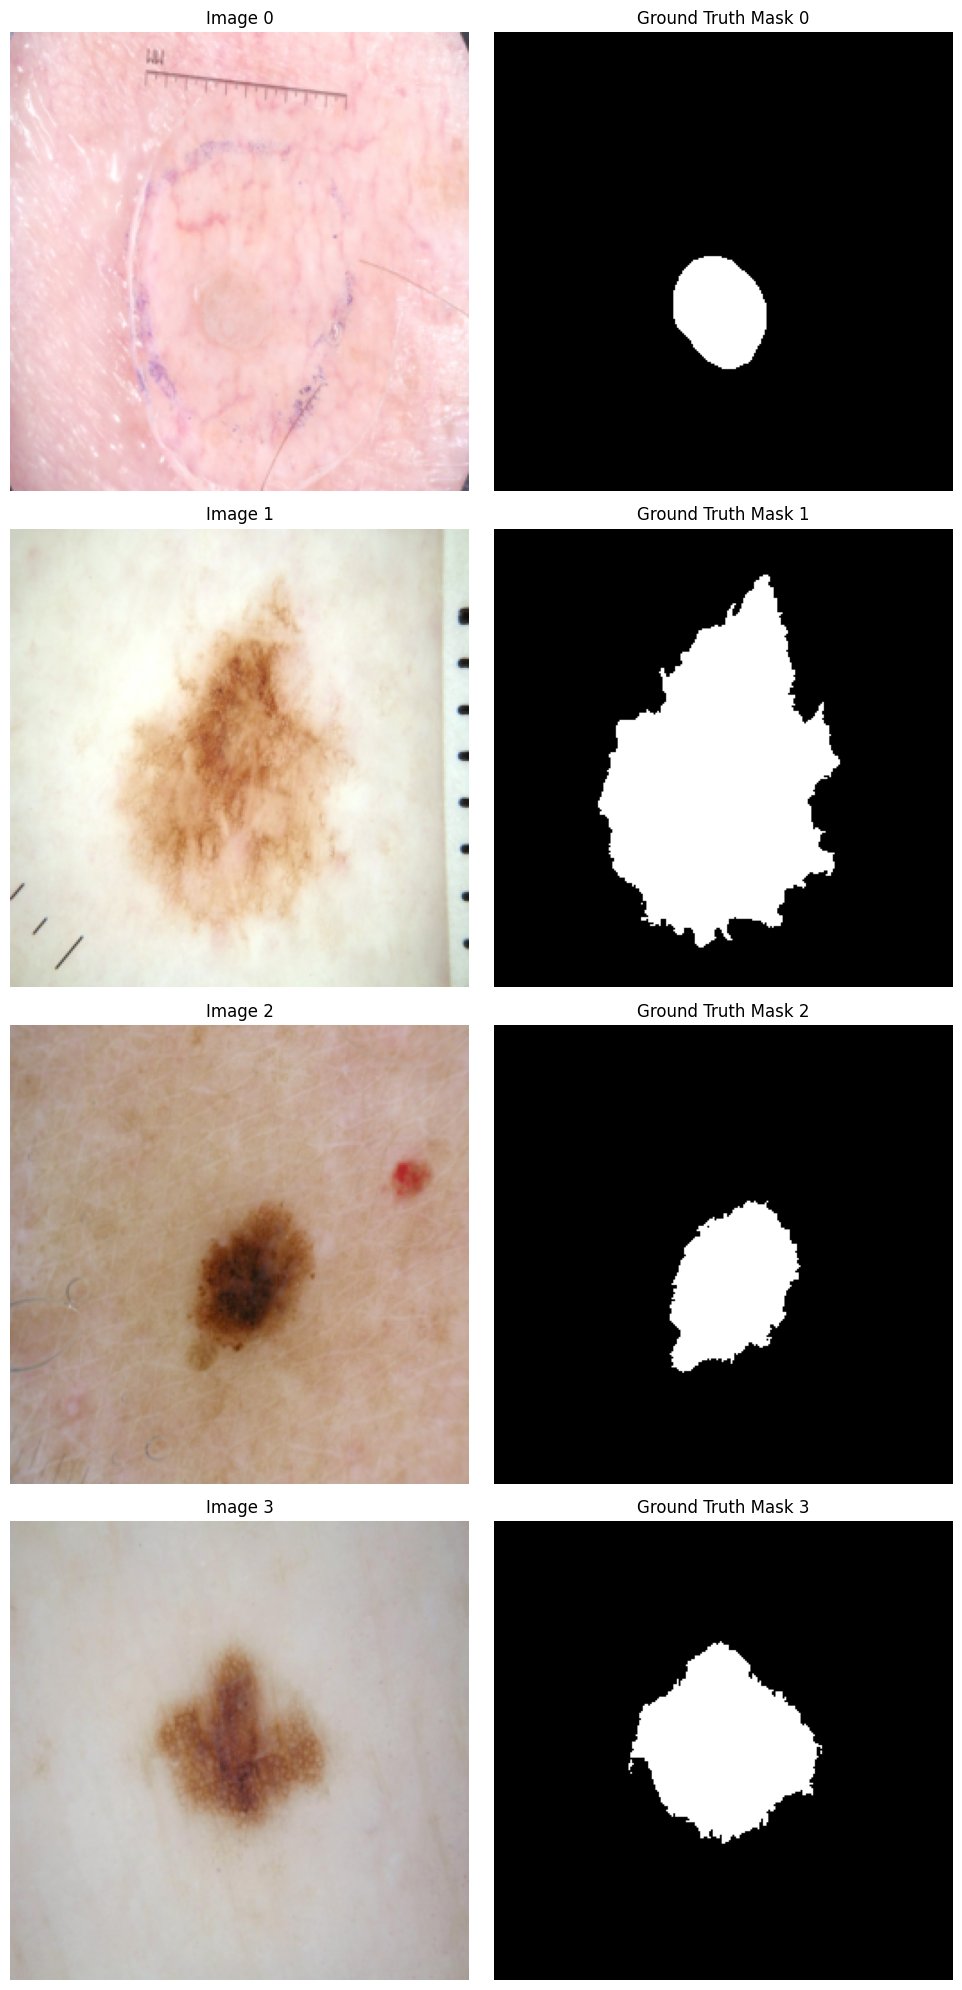

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_isic_batch(images, masks, num_to_show=4):
    """
    Plots images and their corresponding masks side-by-side.
    """
    # ImageNet stats for De-normalization (reversing the math we did in the Dataset)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Cap the number of images to show (in case batch size is huge)
    batch_size = images.shape[0]
    num_to_show = min(batch_size, num_to_show)

    fig, axes = plt.subplots(num_to_show, 2, figsize=(10, 5 * num_to_show))

    # Loop through the batch
    for i in range(num_to_show):
        # 1. Process Image
        img = images[i].permute(1, 2, 0).cpu().numpy() # Move channels to end (H, W, C)
        img = std * img + mean                         # Undo normalization
        img = np.clip(img, 0, 1)                       # Clip values to valid range [0, 1]

        # 2. Process Mask
        mask = masks[i].squeeze().cpu().numpy()        # Remove channel dim: (1, H, W) -> (H, W)

        # 3. Plotting
        # If batch size is 1, axes is 1D array; otherwise 2D array
        ax_img = axes[i, 0] if num_to_show > 1 else axes[0]
        ax_mask = axes[i, 1] if num_to_show > 1 else axes[1]

        ax_img.imshow(img)
        ax_img.set_title(f"Image {i}")
        ax_img.axis('off')

        ax_mask.imshow(mask, cmap="gray")
        ax_mask.set_title(f"Ground Truth Mask {i}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()
batch = next(iter(train_loader))  # this gives one batch
imgs, masks = batch


print(f"Displaying {len(imgs)} samples...")
visualize_isic_batch(imgs, masks)

In [ ]:
%%writefile model_transattunet_r.py
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- IMPROVEMENT 1: Residual Convolution Block ---
# Matches "Residual connection" concept to alleviate gradient vanishing
class ResidualConvBlock(nn.Module):
    """
    Residual Block: x + Conv(x)
    Used to prevent vanishing gradients in deep networks.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

        # If input and output channels differ, we need a 1x1 conv to match them
        # so we can add the residual connection (x + out)
        if in_ch != out_ch:
            self.residual_mapping = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        else:
            self.residual_mapping = nn.Identity()

    def forward(self, x):
        residual = self.residual_mapping(x)
        out = self.conv(x)
        return out + residual  # The "Residual" connection

# --- ATTENTION BLOCKS (SAA Module) ---

class TSA_Block(nn.Module):
    """
    Transformer Self Attention (Eq. 2)
    IMPROVEMENT 2: Added 'Learnt Positional Encoding'
    """
    def __init__(self, in_ch, height=16, width=16, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (in_ch // num_heads) ** -0.5

        # Learnable Position Embedding Parameter
        # The bottleneck size is H/16, W/16. For 256x256 image, this is 16x16.
        self.pos_embedding = nn.Parameter(torch.randn(1, in_ch, height, width))

        self.q_conv = nn.Conv2d(in_ch, in_ch, kernel_size=1)
        self.k_conv = nn.Conv2d(in_ch, in_ch, kernel_size=1)
        self.v_conv = nn.Conv2d(in_ch, in_ch, kernel_size=1)
        self.out_conv = nn.Conv2d(in_ch, in_ch, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Add Position Embedding before Attention
        x = x + self.pos_embedding

        B, C, H, W = x.shape
        q = self.q_conv(x).view(B, self.num_heads, C // self.num_heads, -1).permute(0, 1, 3, 2)
        k = self.k_conv(x).view(B, self.num_heads, C // self.num_heads, -1).permute(0, 1, 3, 2)
        v = self.v_conv(x).view(B, self.num_heads, C // self.num_heads, -1).permute(0, 1, 3, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = self.softmax(attn)

        out = (attn @ v).permute(0, 1, 3, 2).contiguous().view(B, C, H, W)
        return self.out_conv(out)

class GSA_Block(nn.Module):
    """Global Spatial Attention (Eq. 3 & 4)"""
    def __init__(self, in_ch):
        super().__init__()
        self.c_prime = in_ch // 8
        self.conv_mn = nn.Conv2d(in_ch, self.c_prime, kernel_size=1)
        self.conv_w = nn.Conv2d(in_ch, in_ch, kernel_size=1)
        self.out_conv = nn.Conv2d(in_ch, in_ch, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, C, H, W = x.shape
        N = H * W

        m = self.conv_mn(x).view(B, self.c_prime, N)
        n = m.permute(0, 2, 1)
        attention_b = self.softmax(torch.bmm(n, m))

        w = self.conv_w(x).view(B, C, N)
        out = torch.bmm(w, attention_b.permute(0, 2, 1)).view(B, C, H, W)
        return self.out_conv(out)

class SAA_Module(nn.Module):
    """Bridge Module: Eq. 5"""
    def __init__(self, in_ch, height=16, width=16):
        super().__init__()
        self.tsa = TSA_Block(in_ch, height, width)
        self.gsa = GSA_Block(in_ch)
        self.lambda1 = nn.Parameter(torch.zeros(1))
        self.lambda2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return (self.lambda1 * self.tsa(x)) + (self.lambda2 * self.gsa(x)) + x


# --- MAIN MODEL: TransAttUnet_R ---

class TransAttUnet_R(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, img_size=256):
        super().__init__()

        # 1. Encoder (Standard ConvBlocks)
        self.enc1 = ResidualConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ResidualConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ResidualConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = ResidualConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # 2. Bridge (SAA)
        # Calculate bottleneck size: img_size / 16
        # For 256 input, bottleneck is 16x16
        bottleneck_size = img_size // 16

        self.bottleneck_conv = ResidualConvBlock(512, 1024)
        self.saa = SAA_Module(1024, height=bottleneck_size, width=bottleneck_size)

        # 3. Decoder with RESIDUAL Connections
        # We use ResidualConvBlock here to support the "Residual" architecture claim

        # Stage 4
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ResidualConvBlock(1024, 512)

        # Stage 3
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualConvBlock(512, 256)

        # Stage 2
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualConvBlock(256, 128)

        # Stage 1
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualConvBlock(128, 64)

        # Final Output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bridge
        b = self.bottleneck_conv(self.pool4(e4))
        b = self.saa(b)

        # Decoder
        d4 = self.dec4(torch.cat((e4, self.up4(b)), dim=1))
        d3 = self.dec3(torch.cat((e3, self.up3(d4)), dim=1))
        d2 = self.dec2(torch.cat((e2, self.up2(d3)), dim=1))
        d1 = self.dec1(torch.cat((e1, self.up1(d2)), dim=1))

        return torch.sigmoid(self.final_conv(d1))

def test_r():
    x = torch.randn((4, 3, 256, 256))
    model = TransAttUnet_R(img_size=256)
    preds = model(x)
    print(f"TransAttUnet_R Input: {x.shape}")
    print(f"TransAttUnet_R Output: {preds.shape}")

if __name__ == "__main__":
    test_r()

Overwriting model_transattunet_r.py


In [ ]:
# MODEL SETUP
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# LOSS & OPTIMIZER
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# TRAINING LOOP
best_valid_loss = float('inf')
checkpoint_path = "best_model.pth"

# Store history for plotting
history = {'train_loss': [], 'val_loss': []}

for epoch in range(5):
    print(f"\n--- Epoch {epoch+1}/{5} ---")

    # TRAINING
    model.train()
    train_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Print every 10 batches
        if batch_idx % 10 == 0:
            print(f".", end="", flush=True)

    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"\nTrain Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(val_loader)
    history['val_loss'].append(avg_valid_loss)
    print(f"Valid Loss: {avg_valid_loss:.4f}")

    # CHECKPOINTING
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_valid_loss,
        }, checkpoint_path)
        print(f"✅ Model saved to {checkpoint_path}")
    else:
        print("No improvement.")

print("Training Complete!")




--- Epoch 1/5 ---
...........................................................
Train Loss: 0.2143
Valid Loss: 0.1502
✅ Model saved to best_model.pth

--- Epoch 2/5 ---
...........................................................
Train Loss: 0.1388
Valid Loss: 0.1364
✅ Model saved to best_model.pth

--- Epoch 3/5 ---
...........................................................
Train Loss: 0.1235
Valid Loss: 0.1311
✅ Model saved to best_model.pth

--- Epoch 4/5 ---
...........................................................
Train Loss: 0.1146
Valid Loss: 0.1243
✅ Model saved to best_model.pth

--- Epoch 5/5 ---
...........................................................
Train Loss: 0.1081
Valid Loss: 0.1195
✅ Model saved to best_model.pth
Training Complete!
